# Names (Enter your names below)
**Your Name and JHED:** Ryan Nguyen

**Partner's Name and JHED (If applicable):**  Manny Etoh (ietoh4)

# Lab 3: Prediction of Septic Shock in Patients [140 points]

By **Benjamín Béjar Haro** and edited by **Kwame Kutten** and **Joseph Greenstein**

Sepsis is a life-threatening condition caused by an inflammatory immune response to an infection. It is the leading cause of death in hospitals and has a greater risk of mortality in its advanced state, also called *Septic Shock*. Early treatment of Septic Shock can dramatically increase the survival rate. Therefore, a prediction system capable of foreseeing Septic Shock would provide an early intervention window that has the potential to translate into improved patient outcomes. In this lab we look at the problem Septic Shock prediction following the approach described in [Liu et al. 2019](https://doi.org/10.1038/s41598-019-42637-5). Your goal in this lab is to reproduce some of the results in above paper. In particular you will train a a logistic regression model (referred to as GLM in the paper) to predict Septic Shock and will apply it to a test patient dataset.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as date
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

np.random.seed(0) # Fix random number generator for reproducibility
pd.set_option('display.max_columns', None) # Display all columns in pandas

## Read Data
You have been provided with the curated data used in Liu *et al.* which is a subset of the publicly available MIMIC-III database ([Johnson et al. 2016](https://doi.org/10.1038/sdata.2016.35)). The data corresponds to electronic health record data of a large population of patients, and consists of measured values over time for $28$ different features such as, heart rate, blood pressure, respiratory rate, temperature, etc. Each data point represents a particular measurement in time and for a particular patient. The data has been split into training and testing as described in Liu *et al.* and is provided to you in the form of `.csv` files. Inside those files `x` columns correspond to feature values while the `y` column represents the associated label of a particular row of feature values.  Thus $y=0$ means that the patient didn't go into Septic Shock, while a label $y=1$ indicates that the patient eventually went into Septic Shock).

In [2]:
#===========================================
# Read data. Change path if necessary
#===========================================

import io, zipfile

filename = "lab3_data.zip"
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = "gdrive/My Drive/Colab Notebooks" # CHANGE PATH TO LOCATION IF NECESSARY
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./"

archive = zipfile.ZipFile("/".join([path,filename]), 'r')
traindata = pd.read_csv(io.BytesIO(archive.read('glm.training.data.csv')))
testdata = pd.read_csv(io.BytesIO(archive.read('glm.test.data.csv')))

Mounted at gdrive/


Now we display the first ten rows of the training.

In [3]:
traindata.head(10)

,Unnamed: 0,x.hr,x.sbp,x.dbp,x.mbp,x.resp,x.temp,x.cvp,x.pao2,x.fio2,x.gcs,x.bili,x.platelets,x.creat,x.lactate,x.bun,x.ph,x.wbc,x.paco2,x.hgb,x.hct,x.potassium,x.urine,x.resp.sofa,x.nervous.sofa,x.cardio.sofa,x.liver.sofa,x.coag.sofa,x.kidney.sofa,y
0,1,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,0.00000,0,0,0,0
1,2,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,0.00000,0,0,0,0
2,3,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,0.00000,0,0,0,0
3,4,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,0.00000,0,0,0,0
4,5,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,1.10508,0,0,0,0
5,6,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,346.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.49,13.000894,28.5,10.931866,30.624509,4.5,0.0,0,0,1.10508,0,0,0,0
6,7,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,276.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.42,13.000894,31.5,10.931866,30.624509,4.0,0.0,0,0,1.10508,0,0,0,0
7,8,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,228.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.40,13.000894,30.5,10.931866,30.624509,4.3,0.0,0,0,1.10508,0,0,0,0
8,9,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,228.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.40,13.000894,30.5,10.931866,30.624509,4.3,0.0,0,0,1.10508,0,0,0,0
9,10,87.252031,119.411786,61.039926,77.835458,20.242346,37.164892,15.309346,228.0,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.40,13.000894,30.5,10.931866,30.624509,4.3,0.0,0,0,1.10508,0,0,0,0


Now we display the first 50 rows to the test data.  Notice how the 2nd to last column is labeled `patient`.  This dataset contains info from multiple patients whose index is stored in this column.

In [4]:
testdata.head(50)

,Unnamed: 0,hr,sbp,dbp,mbp,resp,temp,cvp,pao2,fio2,gcs,bili,platelets,creat,lactate,bun,ph,wbc,paco2,hgb,hct,potassium,urine,resp.sofa,nervous.sofa,cardio.sofa,liver.sofa,coag.sofa,kidney.sofa,patient,y
0,1,71.000000,134.000000,102.000000,111.000000,20.000000,37.055577,15.309346,127.185075,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.475177,13.000894,37.799131,10.931866,30.624509,5.808235,0.000000,0,0,1.10508,0,0,0,1,0
1,2,59.000000,115.000000,38.000000,58.000000,10.000000,37.055577,15.309346,127.185075,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.475177,13.000894,37.799131,10.931866,30.624509,5.808235,20.000000,0,0,1.10508,0,0,0,1,0
2,3,70.000000,106.000000,35.000000,54.000000,20.000000,37.055577,15.309346,127.185075,24.447134,9.268035,10.335779,232.129378,6.065923,1.893525,35.051098,7.475177,13.000894,37.799131,10.931866,30.624509,5.808235,70.000000,0,0,1.10508,0,0,0,1,0
3,4,70.000000,106.000000,35.000000,54.000000,20.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,1.893525,30.000000,7.475177,16.800000,37.799131,11.100000,32.400002,5.500000,70.000000,0,0,1.10508,0,0,1,1,0
4,5,70.000000,106.000000,35.000000,54.000000,20.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,1.893525,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,70.000000,0,0,1.10508,0,0,1,1,0
5,6,70.000000,106.000000,35.000000,54.000000,20.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,2.000000,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,70.000000,0,0,1.10508,0,0,1,1,0
6,7,62.000000,100.000000,38.000000,53.000000,12.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,2.000000,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,120.000000,0,0,1.10508,0,0,1,1,0
7,8,62.000000,100.000000,38.000000,53.000000,12.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,1.500000,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,120.000000,0,0,1.10508,0,0,1,1,0
8,9,58.000000,101.000000,28.000000,46.000000,12.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,1.500000,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,160.000000,0,0,1.10508,0,0,1,1,0
9,10,57.000000,98.000000,31.000000,47.000000,14.000000,37.055577,15.309346,127.185075,24.447134,9.268035,0.400000,201.000000,1.200000,1.500000,30.000000,7.475177,17.900000,37.799131,11.200000,31.799999,5.500000,190.000000,0,0,1.10508,0,0,1,1,0


The labels are the last column and the data is from the 2nd to the 30th column.  Here we use the `.values` attribute to store the data and labels in numpy arrays

In [5]:
Xtrain = traindata.iloc[:,1:29].values # Rows are patients, columns are clinical indicators
ytrain = traindata.iloc[:,-1].values

Xtest = testdata.iloc[:,1:29].values
ytest = testdata.iloc[:,-1].values

## 1. Normalize Data [10 points]
Normalize the `Xtrain` and `Xtest` such that each column has zero mean and unit standard deviation.  Then for both the training and test data use `np.isclose` to verify that the means and standard deviations of the normalized data are correct.

In [6]:
# Xtrain Normalization
scaler1 = StandardScaler()
Xtrain_norm = scaler1.fit_transform(Xtrain)

Xtrain_NMEANS = np.mean(Xtrain_norm, axis = 0)
Xtrain_NSTDS = np.std(Xtrain_norm, axis = 0)

isTrainMeanNormalized = np.isclose(Xtrain_NMEANS, np.zeros(Xtrain.shape[1], dtype = float))
isTrainStdNormalized = np.isclose(Xtrain_NSTDS, np.ones(Xtrain.shape[1], dtype = float))

print(f'Xtrain mean normalization has occurred: {bool(np.mean(isTrainMeanNormalized))}')
print(f'Xtrain standard deviation normalization has occurred: {bool(np.mean(isTrainStdNormalized))}')

Xtrain mean normalization has occurred: True
Xtrain standard deviation normalization has occurred: True


In [7]:
# Xtest Normalization
scaler2 = StandardScaler()
Xtest_norm = scaler2.fit_transform(Xtest)

Xtest_NMEANS = np.mean(Xtest_norm, axis = 0)
Xtest_NSTDS = np.std(Xtest_norm, axis = 0)

isTestMeanNormalized = np.isclose(Xtest_NMEANS, np.zeros(Xtest.shape[1], dtype = float))
isTestStdNormalized = np.isclose(Xtest_NSTDS, np.ones(Xtest.shape[1], dtype = float))

print(f'Xtest mean normalization has occurred: {bool(np.mean(isTestMeanNormalized))}')
print(f'Xtest standard deviation normalization has occurred: {bool(np.mean(isTestStdNormalized))}')

Xtest mean normalization has occurred: True
Xtest standard deviation normalization has occurred: True


## 2. Train Generalized Linear (Logistic Regression) Model [20 points total]
 * Train a logistic regression model on the normalized data using [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). You should use the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) from `sklearn.linear_model` with a `"log_loss"` loss, `"balanced"` class weights and a `"l1"` lasso penalty.  Specify a value for regularization parameter $\alpha \in (0,1]$ [10 points].
 * Plot the ROC curve and display the AUC [10 points].

In [8]:
# Train and Predict
model = SGDClassifier(loss = "log_loss",  penalty = "l1", alpha = 0.0001, class_weight = "balanced")
model.fit(Xtrain_norm, ytrain)
y_pred = model.predict(Xtest_norm)

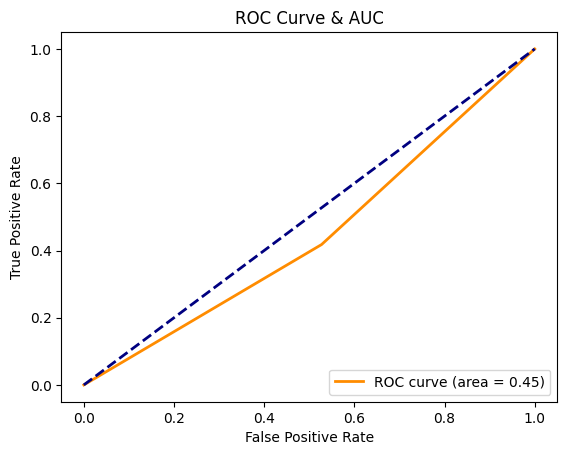

In [9]:
# ROC Curve and AUC
fpr, tpr, threshold = roc_curve(ytest, y_pred)
auc_score = roc_auc_score(ytest, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve & AUC')
plt.legend(loc="lower right")

## 3. Hyperparameter Tuning [30 points total]
 * Refine this model by determining an optimal regularization hyperparameter $\alpha > 0$ which maximizes AUC via **5-fold cross validation** similar to Liu *et al.* You should use [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) from `sklearn.model_selection` to split your training dataset into smaller chunks that you feed to the SGDClassifier. Try several values of $\alpha \in (0,1]$. To save time you may use a small number of iterations (e.g. 5) in this step for your SGDClassifier [20 points].
 * Then display your optimal $\alpha$ [10 points]

In [10]:
alphas = np.geomspace(1e-4, 1, num = 5)
num_alphas = alphas.shape[0]
avg_aucs = np.zeros(num_alphas)
for i in range(num_alphas):
  print(f'TESTING ALPHA VALUE: {alphas[i]}')
  aucs = np.zeros(5)
  kf = StratifiedKFold(n_splits = 5)
  for j, (train_index, test_index) in enumerate(kf.split(Xtrain_norm, ytrain)):
    model = SGDClassifier(loss = "log_loss",  penalty = "l1", alpha = alphas[i], class_weight = "balanced")
    model.fit(Xtrain_norm[train_index], ytrain[train_index])
    y_pred = model.predict(Xtrain_norm[test_index])
    aucs[j] = roc_auc_score(ytrain[test_index], y_pred)
    print(f'Split {j+1}: {aucs[j]}')
  avg_aucs[i] = np.mean(aucs)
  print(" ")
opt_alpha = alphas[np.argmax(avg_aucs)]
print(f'The optimal regularization hyperparameter is {opt_alpha}')

TESTING ALPHA VALUE: 0.0001
Split 1: 0.8921942947398733
Split 2: 0.833778383955061
Split 3: 0.8685121149466571
Split 4: 0.860743642736612
Split 5: 0.8541394369519623
 
TESTING ALPHA VALUE: 0.001
Split 1: 0.8998167582497336
Split 2: 0.8758094769254289
Split 3: 0.8651987535152391
Split 4: 0.86106471789026
Split 5: 0.8521922881158989
 
TESTING ALPHA VALUE: 0.01
Split 1: 0.8972668694638222
Split 2: 0.8635837042293156
Split 3: 0.8521363484578756
Split 4: 0.8505837649167436
Split 5: 0.8444105835665155
 
TESTING ALPHA VALUE: 0.1
Split 1: 0.7829115625160016
Split 2: 0.7452133381922178
Split 3: 0.7192135368851914
Split 4: 0.6923196471026055
Split 5: 0.7192911642751784
 
TESTING ALPHA VALUE: 1.0
Split 1: 0.5
Split 2: 0.5
Split 3: 0.5
Split 4: 0.5
Split 5: 0.5
 
The optimal regularization hyperparameter is 0.001


## 4. Retrain Model [30 points total]
 * Retrain your model using your optimal regularization hyperparameter $\alpha$ from the previous step [10 points].
 * Plot the ROC curve and display it's AUC [10 points].
 * Find the **Operating Point** which gives the best TPR and FPR and add it to the plot [5 points].  
 * Display the training data accuracy at the operating point [5 points].

In [11]:
# Retrain With Optimal Regularization Hyperparameter and Predict
model = SGDClassifier(loss = "log_loss",  penalty = "l1", alpha = opt_alpha, class_weight = "balanced")
model.fit(Xtrain_norm, ytrain)
y_pred = model.predict(Xtest_norm)

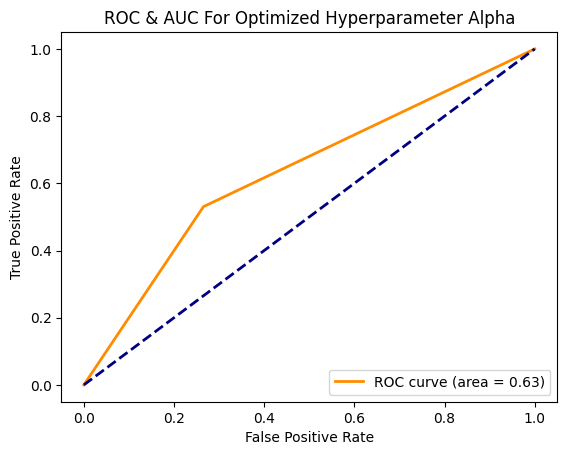

In [12]:
# ROC Curve and AUC
fpr, tpr, threshold = roc_curve(ytest, y_pred)
auc_score = roc_auc_score(ytest, y_pred)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC For Optimized Hyperparameter Alpha')
plt.legend(loc="lower right")
plt.show()

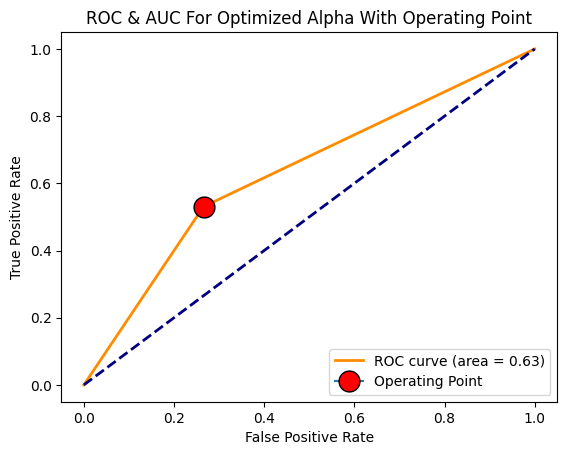

In [13]:
# Plotting Operating Point
plt.figure(fig)
plt.plot(fpr[1], tpr[1], marker = 'o', markersize = 15, markeredgecolor="black",
         markerfacecolor="red", label = 'Operating Point')
plt.title('ROC & AUC For Optimized Alpha With Operating Point')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Training Metrics
print(f'The sensitivity is {recall_score(ytest, y_pred) * 100:.02f}%')
print(f'The positive predictive value is {precision_score(ytest, y_pred) * 100:.02f}%')

print(f'The specificity is {recall_score(ytest, y_pred, pos_label = 0) * 100:.02f}%')
print(f'The negative predictive value is {precision_score(ytest, y_pred, pos_label = 0) * 100:.02f}%')

print(f'The accuracy is {accuracy_score(ytest, y_pred) * 100:.02f}%')

The sensitivity is 53.06%
The positive predictive value is 16.31%
The specificity is 73.46%
The negative predictive value is 94.14%
The accuracy is 71.65%


## 5. Plot Feature Weights [15 points]
The exponentiated coefficients from our model tell us how much each feature is weighted when making a prediction.  Find the weights by exponentiating the coefficients from your model (Get coefficients from the `'coef_` attribute). Plot a bar graph of these weights with their corresponding names.  Your results should be similar to Figure 3 in Liu *et al.*

<BarContainer object of 28 artists>

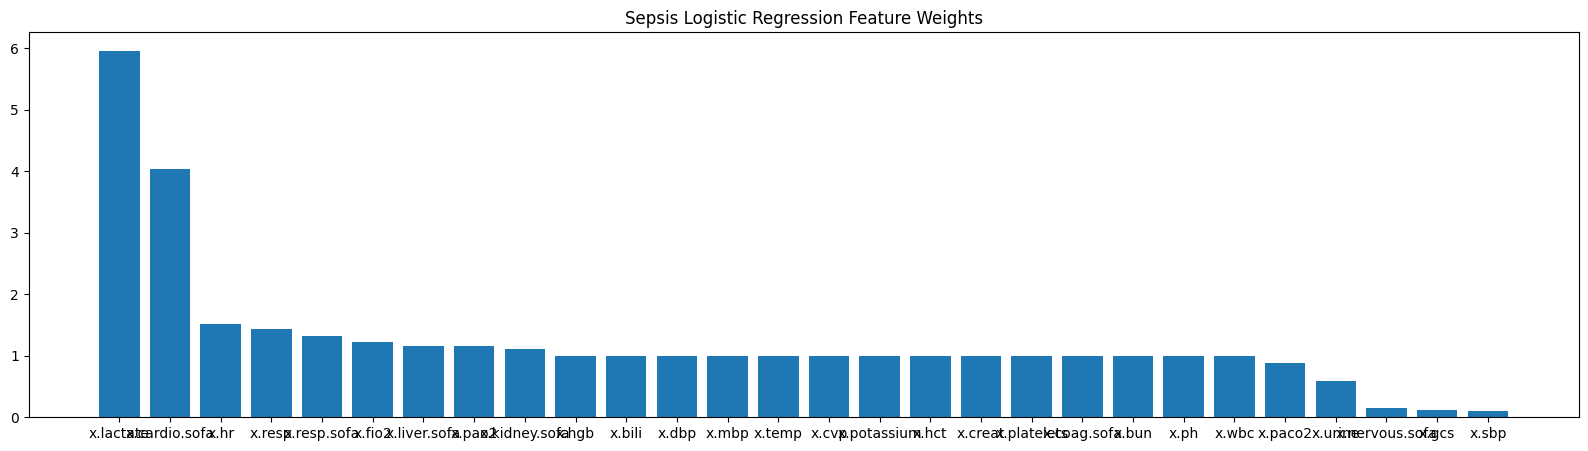

In [15]:
exp_coef = np.transpose(np.exp(model.coef_)).squeeze()
key = np.argsort(exp_coef)[::-1]
exp_coef = exp_coef[key]
featureNames = np.asarray(traindata.iloc[:,1:29].keys())[key]
plt.figure(figsize = (20, 5))
plt.title("Sepsis Logistic Regression Feature Weights")
plt.bar(featureNames, height = exp_coef)

## 6. Test Model on Patient Data [35 points total]
 * Use the patient column from the test dataset to determine the number of patients in our test dataset.  Use the test labels to create an array of this size which is $1$ if the patient went into Septic Shock *at any time* during their hospital stay and $0$ otherwise.  We can be certain that a patient went into Septic Shock if their maximum probability (risk score) attained over their hospital stay excedes some operating threshold.  Therefore you should also create a corresponding array which contains these maximum probabilities [15 points].  

 * Create an ROC curve using these arrays and display the AUC [10 points].
 * Find operating point and add it to the plot [5 points].
 * Display the accuracy for test patients at the operating point [5 points].

In [16]:
# Create Labels and Risk Predictions
numPatients = pd.unique(testdata['patient']).size
labels = np.zeros(numPatients)
pred = np.zeros(numPatients)
for i in range(numPatients):
  patient = testdata.loc[testdata['patient'] == i + 1, :].values
  p = model.predict(patient[:,1:29])

  labels[i] = 1 if 1 in patient else 0
  pred[i] = 1 if 1 in p else 0

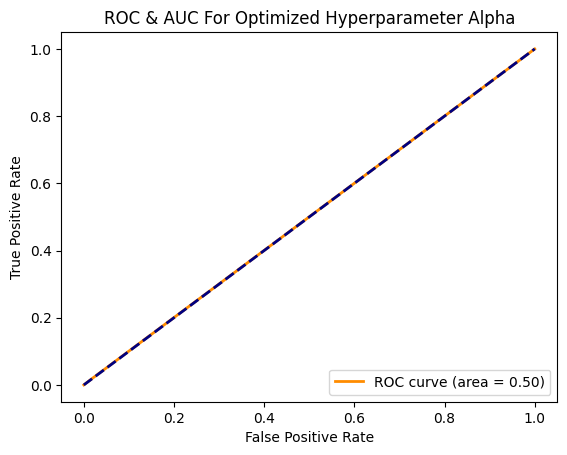

In [17]:
# ROC & AUC
fpr, tpr, threshold = roc_curve(labels, pred)
auc_score = roc_auc_score(labels, pred)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC For Optimized Hyperparameter Alpha')
plt.legend(loc="lower right")
plt.show()

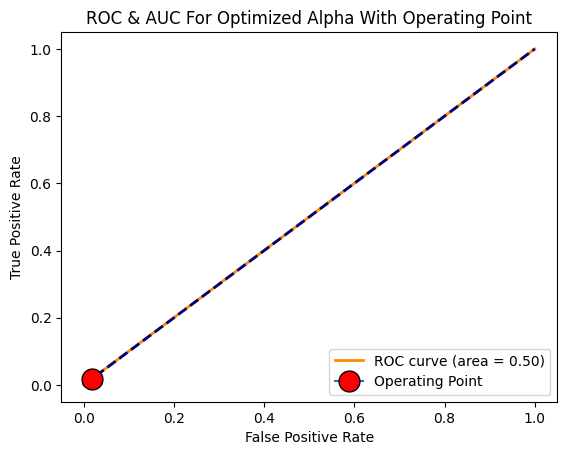

In [18]:
# Operating Point
plt.figure(fig)
plt.plot(fpr[1], tpr[1], marker = 'o', markersize = 15, markeredgecolor="black",
         markerfacecolor="red", label = 'Operating Point')
plt.title('ROC & AUC For Optimized Alpha With Operating Point')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Metrics
print(f'The sensitivity is {recall_score(labels, pred) * 100:.02f}%')
print(f'The positive predictive value is {precision_score(labels, pred) * 100:.02f}%')

print(f'The specificity is {recall_score(labels, pred, pos_label = 0) * 100:.02f}%')
print(f'The negative predictive value is {precision_score(labels, pred, pos_label = 0) * 100:.02f}%')

print(f'The accuracy is {accuracy_score(labels, pred) * 100:.02f}%')

The sensitivity is 1.84%
The positive predictive value is 85.37%
The specificity is 98.23%
The negative predictive value is 15.12%
The accuracy is 16.40%
